In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy
from matplotlib import pyplot, cm
import ipywidgets
import pymc3
import arviz
import typing
import fastprogress
import scipy
import numba

import pyrff

### Specify Synthetic Problem

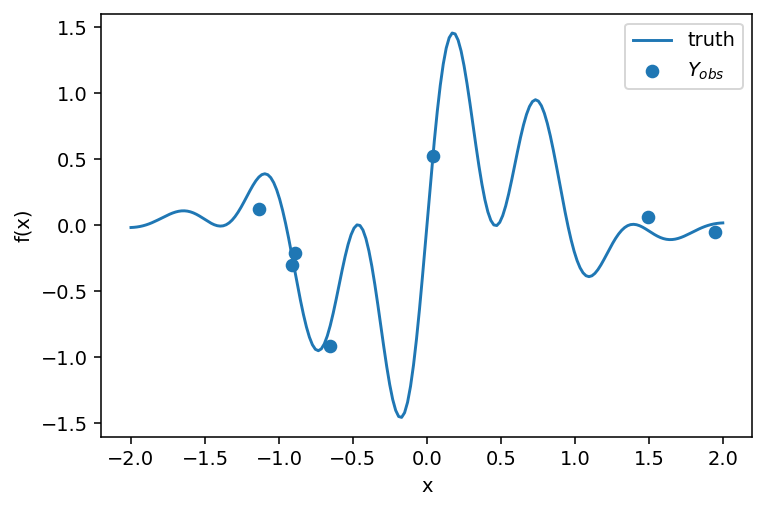

In [3]:
σ_true = 0.1
D = 1
BOUNDS = numpy.array([
    (-2, 2)
    for d in range(D)
])

def truth(x):
    y = numpy.sin((3.2*numpy.pi)*x) + numpy.sin((1*numpy.pi)*x)
    return y * numpy.exp(-x**2)

def observe(x, sigma=σ_true):
    y = truth(x)
    return numpy.random.normal(y[:,0], sigma, size=(len(x),))

# make observations
X = numpy.random.RandomState(2020).uniform(
    low=BOUNDS[:,0],
    high=BOUNDS[:,1],
    size=(7,D)
)
Y = observe(X)

# create coordinates for cross-sections
X_denses = {}
for d, (lb, ub) in enumerate(BOUNDS):
    x_dense = numpy.zeros((200, D))
    x_dense[:,d] = numpy.linspace(lb, ub, 200)
    X_denses[f'D{d}'] = x_dense
del x_dense

# visualize
if D == 1:
    fig, ax = pyplot.subplots(dpi=140)
    ax.plot(X_denses['D0'], truth(X_denses['D0']), label='truth')
    ax.scatter(X, Y, label='$Y_{obs}$')
    ax.set_ylabel('f(x)')
    ax.set_xlabel('x')
    ax.legend()
    pyplot.show()

### Fit Gaussian Process with `PyMC3`

In [4]:
with pymc3.Model() as pmodel:
    # as lengthscale, take the width of every bound
    span = numpy.ptp(BOUNDS, axis=1)
    ls = pymc3.Lognormal('ls', mu=span*0.1, sd=1, shape=span.shape)

    # use log(height) as scaling prior mean
    scaling = pymc3.Lognormal('scaling', mu=0, sd=0.5)

    # inform observation noise prior from reference data
    sigma = pymc3.Lognormal('sigma', mu=σ_true)

    # construct the GP
    mean_func = pymc3.gp.mean.Zero() # for RFF, the mean must be 0 !!!
    cov_func = scaling**2 * pymc3.gp.cov.ExpQuad(
        input_dim=D,
        ls=ls
    )
    gp = pymc3.gp.Latent(mean_func=mean_func, cov_func=cov_func)

    if X is not None:
        f = gp.prior('f', X=X)
        # set up likelihood                
        # note that `sigma` could also be a function - see Marginal Likelihood Example notebook from PyMC3
        L = pymc3.Normal(
            'L',
            mu=f, sigma=sigma,
            observed=Y
        )
        
with pmodel:
    mp = pymc3.find_MAP()
    
with pmodel:
    trace = pymc3.sample()

C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the f

C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional i

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 184 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


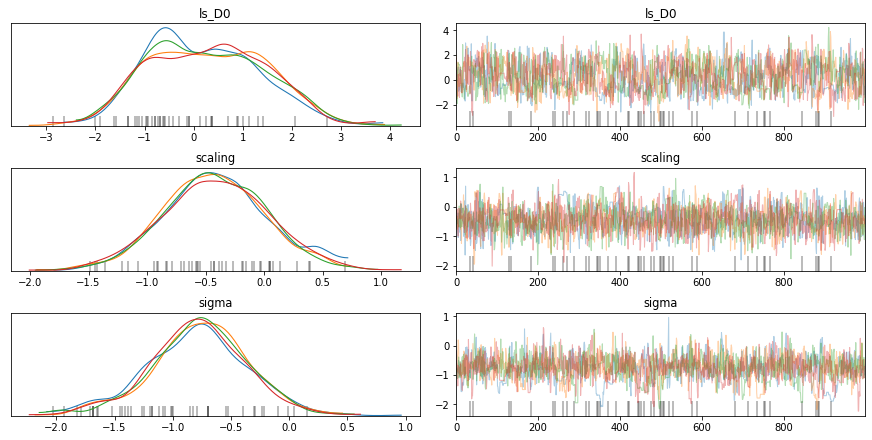

In [5]:
axs = arviz.plot_trace(trace, var_names=['ls', 'scaling', 'sigma'], transform=numpy.log)
for d, axr in zip(range(D), axs):
    dname = f'D{d}'
    for ax in axr:
        ax.set_title(f'ls_{dname}')
pyplot.show()

In [6]:
# add observations, conditioned on slices of x-coordinates to the model
with pmodel:
    if X is not None:
        for dname, x_dense in X_denses.items():
            gp.conditional(dname, Xnew=x_dense)
    else:
        for dname, x_dense in X_denses.items():
            gp.prior(dname, X=x_dense)

In [7]:
# sample the GP at those coordinates, using the MAP hyperparameters
with pmodel:
    pp_map = pymc3.sample_posterior_predictive(
        [mp]*1000,
        var_names=list(X_denses.keys()),
        random_seed=None
    )

In [8]:
# also sample the GPs created from hyperparameter posterior samples
with pmodel:
    pp_mcmc = pymc3.sample_posterior_predictive(
        trace,
        var_names=list(X_denses.keys()),
        random_seed=None
    )

### Sample RFF approximations

In [9]:
M = 200
rffs_map = [
    pyrff.sample_rff(
        lengthscales=mp['ls'],
        scaling=mp['scaling'],
        noise=mp['sigma'],
        # because the model uses the ExpQuad kernel:
        kernel_nu=numpy.inf,
        X=X,
        Y=Y,
        M=M,
    )
    for i in range(3000)
]

rffs_mcmc = [
    pyrff.sample_rff(
        lengthscales=trace['ls'][i],
        scaling=trace['scaling'][i],
        noise=trace['sigma'][i],
        # because the model uses the ExpQuad kernel:
        kernel_nu=numpy.inf,
        X=X,
        Y=Y,
        M=M,
    )
    for i in range(500)
]

### Compare RFF approximations with MAP

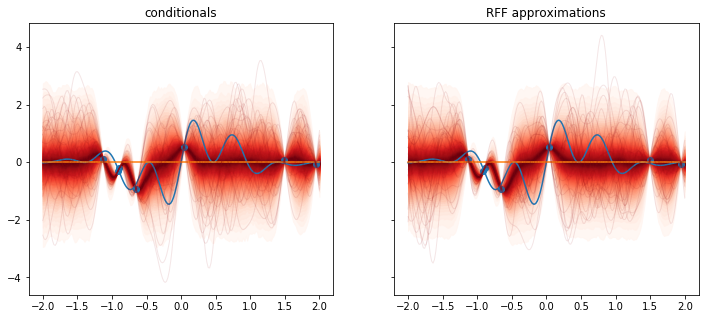

In [10]:
pp = pp_map
rffs = rffs_map

fig, axs = pyplot.subplots(nrows=D, ncols=2, figsize=(12, 5*D), squeeze=False, sharey='row')

for d, (left, right) in enumerate(axs):
    dname = f'D{d}'
    x_dense = X_denses[dname]
    
    # plot functions
    for fname, f in [
            ('truth', truth),
            ('GP mean function', lambda x: gp.mean_func(x).eval())
        ]:
        left.plot(x_dense[:,d], f(x_dense), label=fname)
        right.plot(x_dense[:,d], f(x_dense), label=fname)
    
    # plot conditionals and approximations
    pymc3.gp.util.plot_gp_dist(left, pp[dname], x_dense[:,d])
    pymc3.gp.util.plot_gp_dist(right, numpy.array([
        f_rff(x_dense)
        for f_rff, _, _ in rffs
    ]), x_dense[:,d])
    
    if D == 1:
        left.scatter(X[:,d], Y, label='$Y_{obs}$')
        right.scatter(X[:,d], Y, label='$Y_{obs}$')

axs[0,0].set_title('conditionals')
axs[0,1].set_title('RFF approximations')
pyplot.show()

### Run minimization on the RFF approximations to obtain $p(x_*|X,Y)$ samples

In [11]:
pp = pp_map
rffs = rffs_map

def multi_start_fmin(fun, x0s):
    x_peaks = [
        scipy.optimize.fmin(fun, x0=x0, disp=False)
        for x0 in x0s
    ]
    y_peaks = [
        fun(x)
        for x in x_peaks
    ]
    ibest = numpy.argmin(y_peaks)
    return x_peaks[ibest], y_peaks[ibest]

x_star_x = []
x_star_y = []
for _, f_rff_njit, g_rff_njit in fastprogress.progress_bar(rffs):
    x_best, y_best = multi_start_fmin(
        fun=f_rff_njit,
        x0s=numpy.random.uniform(low=BOUNDS[:,0], high=BOUNDS[:,1], size=(50, D)),
    )
    x_star_x.append(x_best)
    x_star_y.append(y_best)
x_star_x = numpy.array(x_star_x)
x_star_y = numpy.array(x_star_y)

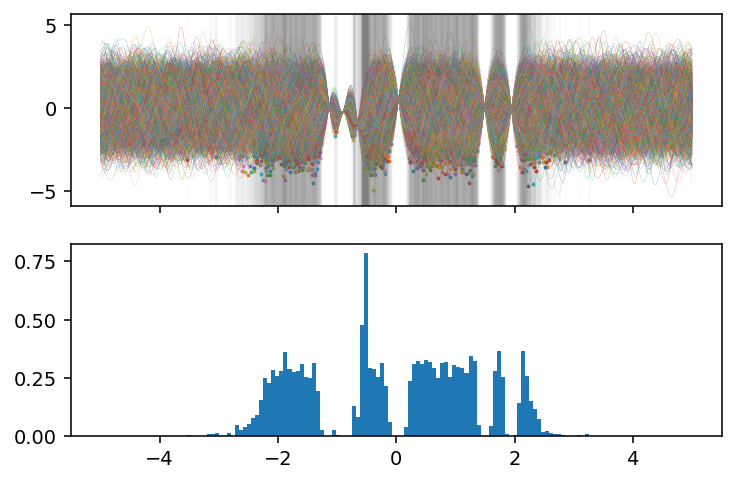

In [12]:
if D == 1:
    fig, (ax, axh) = pyplot.subplots(dpi=140, nrows=2, sharex='col')
    x_dense = numpy.linspace(-5,5, 500)[:,numpy.newaxis]
    for (_, f_rff_compiled, _), best_x, best_y in zip(rffs, x_star_x, x_star_y):
        ax.plot(
            x_dense,
            f_rff_compiled(x_dense),
            linewidth=0.1,
        )
        ax.axvline(best_x, color='grey', alpha=0.02)
        ax.scatter(
            [best_x],
            [best_y],
            s=1
        )
        #ax.set_xlim(-2,2)
    axh.hist(numpy.array(x_star_x)[:,0], bins=100, density=True)
    pyplot.show()